# Sage Shaw

### ME 571 - Spring 2018

# HW 3 - Problem 3

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import subprocess
import pandas as pd

import pickle

import multiprocessing
from math import log

my_proc_count = multiprocessing.cpu_count()

# Donna's Node Centered

In [4]:
%%bash
mpicc demo_util.c hw3p3_node.c -o bin/hw3p3_node -lm
mpirun -n 4 bin/hw3p3_node -p 5 --itermax 100 --tol 1.0e-10 > csv/results_node_CG.csv

iterations: 64
residual: 3.71719e-16
nodes: 129
error: 0.000401644


<IPython.core.display.Javascript object>


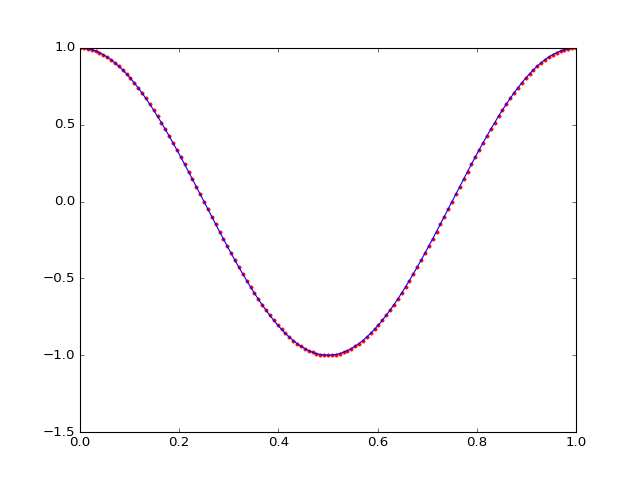

In [5]:
A = np.genfromtxt('csv/results_node_CG.csv', delimiter=',')
print("iterations: %d" % A[-2])
print("residual: %g" % A[-1])
A = A[:-2]
print("nodes: %d" % len(A))
x = np.linspace(0,1,len(A))
print("error: %g" % np.max(np.abs(A - np.cos(2*np.pi*x))))
plt.plot(x,A,'r.')
plt.plot(x, np.cos(2*np.pi*x), 'b-')

# Some Python Code to help with debuging

In [84]:
def cg_solve(A, x, b, tol, max_iter=10**9):
    #n = len(x)
    #N = int(np.sqrt(n))
    #assert N**2 == n
    #assert N>= 3
    x_old = x
    r = b - A.dot(x)
    res_norms = [np.linalg.norm(r)]
    
    iterations = 1
    delta = np.dot(r, r)
    #print("delta: %f" % delta)
    b_delta = np.dot(b,b)
    p = r
    
    while delta > b_delta * tol**2 and iterations <= max_iter:
        print('delta: %f'%delta)
        s = A.dot(p)
        if iterations in (1,2):
            #print(r.reshape((len(r),1)))
            #print(p.reshape((len(p),1)))
            #print(s.reshape((len(s),1)))
            pass
        alpha = delta/np.dot(p,s)
        #print("alpha: %f" % alpha)
        x_new = x_old + alpha*p
        
        r -= alpha * s
        res_norms.append(np.linalg.norm(r))
        delta_new = np.dot(r,r)
        #print("delta_new %f" % delta_new)
        p = r + p * delta_new/delta
        x_old, delta = x_new, delta_new
        #print("delta: %f" % delta)
        iterations += 1
    #cond = (1+np.cos(np.pi/(N+1)))/(1-np.cos(np.pi/(N+1)))
    return x_new, iterations, res_norms

delta: 2.009992
delta: 0.507734
delta: 0.184173
delta: 0.159242
delta: 0.067617
delta: 0.073630
delta: 0.045020
delta: 0.036794
delta: 0.035730
delta: 0.024175


<IPython.core.display.Javascript object>


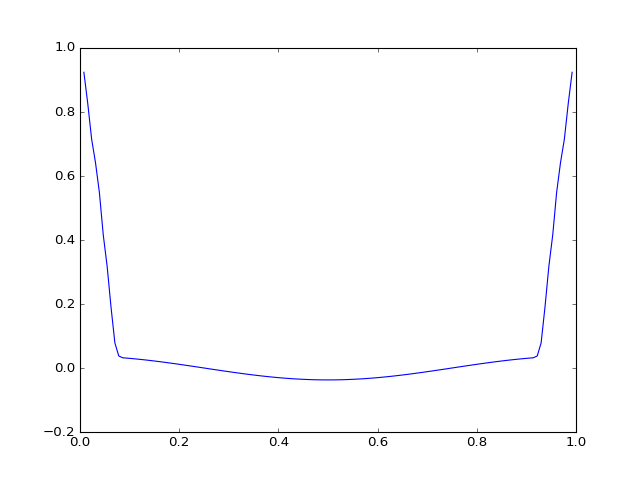

11
error: 0.962762


In [85]:
def foo(x):
    return -(2*np.pi)**2*np.cos(2*np.pi*x)

N = 127
h = 1/(N+1)
xs = np.linspace(h,1-h,N)
A = np.diag([2]*N) + np.diag([-1]*(N-1),k=1) + np.diag([-1]*(N-1),k=-1)
b = np.array([-h**2*foo(xi) for xi in xs])
b[0] += 1
b[-1] += 1

u = np.zeros(N)
u_new, iterations, res_norms = cg_solve(A,u, b, tol=10**-5, max_iter=10)

plt.plot(xs, u_new)
print(iterations)
print("error: %g" % np.max(np.abs(u_new - np.cos(2*np.pi*xs))))

In [82]:
-0.105000 + 1.012527/2.736366 * 1.142474

0.317745265727611

# Part (a)

The code below verifies that I get the same results regardless of the number of processes used, and that the results match the expected results provided on the homework. Additionally it shows second order scaling.

In [6]:
# node centered
my_num = 6
ns = [2**i for i in range(my_num)]
ps = [7-i for i in range(my_num)]
for n,p in zip(ns,ps):
    print((n,p))
    cmd = 'mpirun -n '+ str(n) + ' bin/hw3p3_node -p ' + str(p) + ' --itermax 100000 --tol 1.0e-10'
    f = open('csv/hw3_p3_a_results_node_' + str(n) + 'proc.csv','w')
    process = subprocess.call(cmd.split(), stdout=f)
    f.close()

(1, 7)
(2, 6)
(4, 5)
(8, 4)
(16, 3)
(32, 2)


In [89]:
data = {}
columns = ['Processes', 'iterations', 'residual', 'error']
df = pd.DataFrame(columns=columns)
for n in [2**i for i in range(my_num)]:    
    A = np.genfromtxt('csv/hw3_p3_a_results_node_' + str(n) +'proc.csv', delimiter=',')
    iterations = A[-2]
    residual = A[-1]
    A = A[:-2]
    cells = len(A)
    h = 1/cells
    x = np.linspace(0,1,len(A))
    error = np.max(np.abs(A - np.cos(2*np.pi*x)))
    
    data_row = {'Processes': n, 'iterations': iterations, 'residual': residual, 'error':error}
    df = df.append(pd.Series(data=data_row, name=str(n)))
print(df)

    Processes  iterations      residual     error
1         1.0        64.0  2.912598e-15  0.000402
2         2.0        64.0  7.984258e-16  0.000402
4         4.0        64.0  3.717194e-16  0.000402
8         8.0        64.0  3.460777e-16  0.000402
16       16.0        64.0  4.249061e-16  0.000402
32       32.0        64.0  3.686814e-16  0.000402


In [21]:
proc_pow_2 = int(log(my_proc_count,2))
powers = range(5,18)
ps = [p-proc_pow_2 for p in powers]
print(ps)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [19]:
# node centered second order convergence
for p in ps:
    cmd = 'mpirun -n '+str(my_proc_count)+' bin/hw3p3_node -p ' + str(p) + ' --itermax 10000000 --tol 1.0e-14'
    f = open('csv/hw3_p3_c_results_node_N_' + str(2**(p+proc_pow_2)) + '.csv','w')
    process = subprocess.call(cmd.split(), stdout=f)
    f.close()

               N  iterations      residual         error
32          32.0        16.0  1.698779e-16  6.437929e-03
64          64.0        32.0  2.514066e-16  1.607155e-03
128        128.0        64.0  4.249061e-16  4.016436e-04
256        256.0       128.0  4.996915e-16  1.004018e-04
512        512.0       256.0  8.327912e-16  2.509989e-05
1024      1024.0       512.0  1.190599e-15  6.274937e-06
2048      2048.0      1024.0  2.647381e-15  1.568732e-06
4096      4096.0      2048.0  3.126492e-15  3.921829e-07
8192      8192.0      4096.0  7.004958e-15  9.804574e-08
16384    16384.0      8193.0  7.823753e-15  2.451118e-08
32768    32768.0     16442.0  9.911882e-15  6.127634e-09
65536    65536.0     32949.0  7.871467e-15  1.534184e-09
131072  131072.0     66650.0  9.804916e-15  3.862265e-10


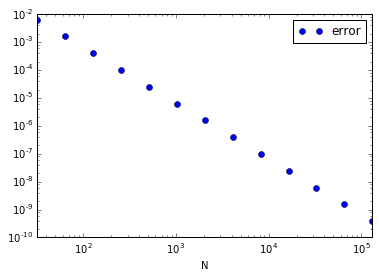

In [90]:
data = {}
highest_power=15
columns = ['N', 'iterations', 'residual', 'error']
df = pd.DataFrame(columns=columns)
for p in ps:    
    A = np.genfromtxt('csv/hw3_p3_c_results_node_N_' + str(2**(p+proc_pow_2)) +'.csv', delimiter=',')
    iterations = A[-2]
    residual = A[-1]
    A = A[:-2]
    nodes = len(A)
    h = 1/(nodes-1)
    x = np.linspace(0,1,len(A))
    error = np.max(np.abs(A - np.cos(2*np.pi*x)))
    
    data_row = {'N': (2**(p+proc_pow_2)), 'iterations': iterations, 'residual': residual, 'error':error}
    df = df.append(pd.Series(data=data_row, name=str(2**(p+proc_pow_2))))
print(df)
df.plot(x='N', y='error', loglog=True, style='bo')

# Part (b)

Strong and weak scaling results

For weak scaling the problem size doubles each time the process count doubles. 

Weak scaling may be an inapropriate measure for this problem and may be generally inapropriate for iterative methods. It assumes that if the problem size doubles, that the number of FLOPs doubles, however, what actually doubles is the number of FLOPS $\textit{per iteration}$. Of course, the bigger the problem size, the more iterations are required. This is why the scaling results below appear poor at first glance.

In general CG should take no more iterations that the number of equations in the system. In practice we see that it takes rougly half as many iterations as there are rows of the matrix. So when the problem size doubles, and the process count doubles, we hope for each iteration to take the same amount of time, but for there to be twice as many iterations. This should result in the total time doubling which is about what we see.

The strong scaling results 

In [92]:
%%capture
#generate data
data = {}
columns = ['N', 'Time']
df = pd.DataFrame(columns=columns)

for procs in [1, 2, 4, 8, 16]:
    p_pow_2 = int(log(procs))
    cmd = 'mpirun -n '+str(procs)+' bin/hw3p3_node -p ' + str(15) + ' --itermax 10000000 --tol 1.0e-14'
    file = open("csv/results.csv", "w")
    tr = %timeit -n 1 -r 1 -o p = subprocess.call(cmd.split())
    file.close()
    data_row = {'N': 2**(int(log(procs,2))+15), 'Time': tr.best}
    df = df.append(pd.Series(data=data_row, name=procs))
weak_scaling_file = open('weak_scaling.pickle','wb')
pickle.dump(df, weak_scaling_file)
weak_scaling_file.close()

In [93]:
print(df)

           N        Time
1    32768.0   14.769550
2    65536.0   32.261546
4   131072.0   72.161535
8   262144.0  150.843571
16  524288.0  339.165178


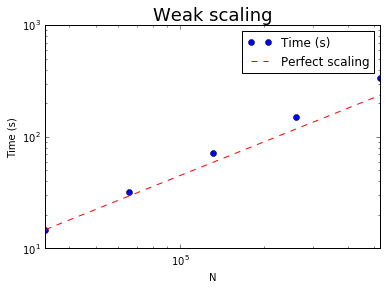

In [129]:
weak_scaling_file = open('weak_scaling.pickle','rb')
df = pickle.load(weak_scaling_file)
weak_scaling_file.close()

df.plot(x='N', y='Time', style='bo', loglog=True)

# Plot best-fit speed-up line
#t_weak = times

plt.plot(df['N'].values, 
         [df['Time'][1]*2**i for i in range(len(df['N'].values))],  'r--' )

plt.title('Weak scaling', fontsize=18)
plt.xlabel('N')
plt.ylabel("Time (s)")
plt.legend(['Time (s)','Perfect scaling'])

For strong scaling, the problem size is fixed and the number of processes increases.

In [123]:
%%capture
#generate data
data = {}
columns = ['Processes', 'Time']
df = pd.DataFrame(columns=columns)

for procs in [1,2,4,8, 16]:
    p_pow_2 = int(log(procs,2))
    cmd = 'mpirun -n '+str(procs)+' bin/hw3p3_node -p ' + str(15-p_pow_2) + ' --itermax 10000000 --tol 1.0e-14'
    file = open("csv/results.csv", "w")
    tr = %timeit -n 1 -r 1 -o p = subprocess.call(cmd.split())
    file.close()
    data_row = {'Processes': procs, 'Time': tr.best}
    df = df.append(pd.Series(data=data_row, name=procs))
strong_scaling_file = open('strong_scaling.pickle','wb')
pickle.dump(df, strong_scaling_file)
strong_scaling_file.close()

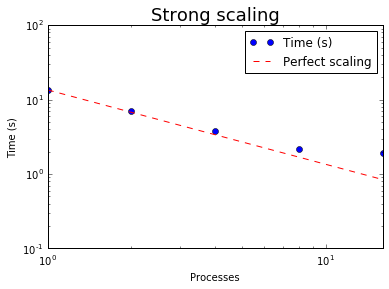

In [130]:
strong_scaling_file = open('strong_scaling.pickle','rb')
df = pickle.load(strong_scaling_file)
strong_scaling_file.close()

df.plot(x='Processes', y='Time', style='bo', loglog=True)

# Plot best-fit speed-up line
#t_weak = times

plt.plot(df['Processes'].values,
         [df['Time'][1]]*1/df['Processes'].values,  'r--' )

plt.title('Strong scaling', fontsize=18)
plt.xlabel('Processes')
plt.ylabel("Time (s)")
plt.legend(['Time (s)','Perfect scaling'])